In [14]:

%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [15]:
import os
from google.colab import userdata

os.environ["GEMINI_API_KEY"] = userdata.get("GEMINI_API_KEY")

In [16]:
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [17]:
os.environ['LANG_SIMTH'] = userdata.get('LANG_SIMTH')

In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add,multiply,divide]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=os.environ["GEMINI_API_KEY"] ,temperature=0.4)
llm_with_tools = llm.bind_tools(tools)

In [19]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage , SystemMessage



sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


def assistant(state: MessagesState) -> MessagesState:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

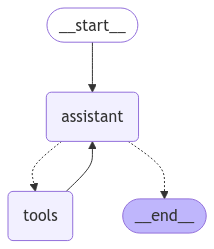

In [20]:
from langgraph.graph import START, END ,StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import display, Image
from langgraph.graph.state import CompiledStateGraph

builder: StateGraph = StateGraph(state_schema=MessagesState)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","assistant")


react_graph:CompiledStateGraph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [21]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [22]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (eff4fe06-dbf6-4501-a22c-b09cf58d2085)
 Call ID: eff4fe06-dbf6-4501-a22c-b09cf58d2085
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (51404fb0-a9bb-40cb-a76a-6e083a6711ad)
 Call ID: 51404fb0-a9bb-40cb-a76a-6e083a6711ad
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (3e0c6e7d-6c27-4055-a782-ca2ef675df1a)
 Call ID: 3e0c6e7d-6c27-4055-a782-ca2ef675df1a
  Args:
    a: 14.0
    b: 5.0
========

In [23]:
messages = [HumanMessage(content="First Add 3 and 4 then multiply answer with 2 and then divide answer with 5. Dont perform division initially")]
messages = react_graph.invoke({"messages": messages})

In [24]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

First Add 3 and 4 then multiply answer with 2 and then divide answer with 5. Dont perform division initially
================================== Ai Message ==================================
Tool Calls:
  add (01dff841-c7a1-4730-97af-838874fc1d0f)
 Call ID: 01dff841-c7a1-4730-97af-838874fc1d0f
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (d283ec31-1f15-44ce-ba6a-5079a9beec5b)
 Call ID: d283ec31-1f15-44ce-ba6a-5079a9beec5b
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (4e008d70-df36-40bd-94e5-25f43e0ee5b4)
 Call ID: 4e008d70-df36-40bd-94e5-25f43